In [2]:
import pandas as pd
from io import StringIO
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

## Parameters 

In [3]:
species = "human" # "mouse" , "macaque" , "human"
alignment = "chrM" # "chrM" , "nuDNA" , "mmr", "emr"

def get_ages(species):
    if species == 'macaque':
        tissue_order = ['Younger','Interm_1','Interm_2', 'Older']
    elif species == 'mouse':
        tissue_order = ['Younger', 'Older']
    elif species == 'human':
        tissue_order = ['Younger','Intermediate', 'Older']
    else:
        tissue_order = None
    return tissue_order

age_order = get_ages(species)


def get_tissues(species):
    if species == 'macaque':
        tissue_order = ['Oo', 'M', 'Li']
    elif species == 'mouse':
        tissue_order = ['Oo', 'M', 'Br']
    elif species == 'human':
        tissue_order = ['Oo', 'Sa', 'Bl']
    else:
        tissue_order = None
    return tissue_order

tissue_order = get_tissues(species)


# Mt genome size based on species
def get_genome_size(species):
    if species == 'macaque':
        genome_size = 16564
    elif species == 'mouse':
        genome_size = 16300
    elif species == 'human':
        genome_size = 16569
    else:
        genome_size = None
    return genome_size

genome_size = get_genome_size(species)

## Data

### Filter by mean DCS depth

In [123]:
def filter_dcs_depth(df):
    if species == 'human':
        df = df[df['MeanReadDepth']>40]
    else:
        df = df[df['MeanReadDepth']>90]
    return df
    # print("# Size after filtering by mean DCS depth: " + str(denovo.shape[0]))

### Import seq depth

In [124]:
def get_depth(species):
    # Seq depth information.
    depth = pd.read_table( f"{species}/meanReadDepths.{alignment}.{species}.txt", names=['SRR_ID','MeanReadDepth','Nucleotides'], sep='\s+' )
    depth['Species'] = species
    # Remove merged samples.
    depth = depth[~depth['SRR_ID'].str.contains('merged')]
    # Drop samples below minimum Mean Read Depth.
    depth = filter_dcs_depth(depth)
    return depth

get_depth(species)

,SRR_ID,MeanReadDepth,Nucleotides,Species
0,hs001_Bl,194.192709,3217579,human
1,hs001_Oo1,1719.972780,28498229,human
2,hs002_Oo1,2426.180457,40199384,human
3,hs002_Oo3,344.547710,5708811,human
4,hs002_Oo5,1785.242682,29579686,human
...,...,...,...,...
89,hs023_Oo1,1959.128734,32460804,human
90,hs023_Oo2,1087.038083,18011134,human
91,hs023_Oo3,2201.843020,36482337,human
92,hs023_Oo4,1130.984127,18739276,human


### Import annotations and export sum of nucleotides

In [ ]:
def get_annot(species):
    # Species annotations.
    annot = pd.read_table( f"annotations_{species}.txt" )
    # Seq depth info.
    depth = get_depth(species)
    # Add seq depth to annotations.
    annot = pd.merge( annot, depth[['SRR_ID','MeanReadDepth','Nucleotides']], how='right' )

    # # Export annotations including merged samples.
    # annot.to_csv( f"annotations_{species}_merged.txt", sep='\t', index=None )

    # Remove merged samples.
    annot = annot[~annot['SRR_ID'].str.contains('merged')]

    # Export annotations with seq depth.
    annot.to_csv( f"tables/annotations.seqDepth.{alignment}.{species}.txt", sep='\t', index=None )

    return annot


def get_sum_nucleotides():
    list_dfs = []
    for species in ['mouse','macaque','human']:
        annot = get_annot(species)
        annot['Species'] = species
        list_dfs.append(annot)

    df = pd.concat(list_dfs)

    # Export annotations with seq depth.
    df.to_csv( f"tables/annotations.seqDepth.{alignment}.txt", sep='\t', index=None )

    # Get nucleotides sequenced per condition.
    sum_nucleotides = df.groupby(['Species','Tissue','Age_group'])['Nucleotides'].sum().reset_index()
    # Export
    sum_nucleotides.to_csv( f"sum_nucleotides_per_condition.{alignment}.tab", sep='\t', index=None )

    return sum_nucleotides


sum_nucleotides = get_sum_nucleotides()
sum_nucleotides

,Species,Tissue,Age_group,Nucleotides
0,human,Bl,Intermediate,5310791
1,human,Bl,Older,11250847
2,human,Bl,Younger,7738150
3,human,Oo,Intermediate,556737175
4,human,Oo,Older,539602351
5,human,Oo,Younger,451721281
6,human,Sa,Intermediate,9702348
7,human,Sa,Older,7567919
8,human,Sa,Younger,8775050
9,macaque,Ht,Interm_2,192591560


## Import de novo indels

In [ ]:
# Get de novo indels.
denovo = pd.read_table( f"indels/indels.denovo_{alignment}_{species}.tab" )
denovo

## Filter depending on Variant Hotspot results

### Filter by mutations observed in more than one individual

,CHROM,POS,REF,ALT,INFO,SRR_ID,value,Species,AC,AF,...,Version,relin_POS,Tissue_type,Classification,Mutation_ID,Pedigree_shared,Filter_ID,Region,Region_size,Individuals_Share
0,chrM,11865,A,AC,SB=1.80374;AF=0.00170358;AC=0,hs001_Bl,.:1:0.00515464:1.80374,human,1.0,0.005155,...,original,NaN,somatic,Somatic de novo,11865_A_AC,None,hs001_11865,non-D-loop,15447,4
1,chrM,14618,A,AC,SB=1.92405;AF=0.00653595;AC=0,hs001_Bl,.:1:0.00653595:1.92405,human,1.0,0.006536,...,original,NaN,somatic,Somatic de novo,14618_A_AC,None,hs001_14618,non-D-loop,15447,1
2,chrM,5893,A,AC,SB=1.88737;AF=0.00148588;AC=0,hs002_Oo1,.:1:0.000319081:1.88737,human,1.0,0.000319,...,original,NaN,germline,Germline de novo,5893_A_AC,None,hs002_5893,non-D-loop,15447,3
3,chrM,14208,AACT,A,SB=2.56573;AF=0.00286533;AC=0,hs002_Oo3,.:1:0.00286533:2.56573,human,1.0,0.002865,...,original,NaN,germline,Germline de novo,14208_AACT_A,None,hs002_14208,non-D-loop,15447,1
4,chrM,7093,T,TC,SB=2.20303;AF=0.000511509;AC=0,hs002_Oo5,.:1:0.000511509:2.20303,human,1.0,0.000512,...,original,NaN,germline,Germline de novo,7093_T_TC,None,hs002_7093,non-D-loop,15447,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,chrM,864,A,AATGTT,SB=2.38069;AF=0.000582072;AC=0,hs006_Oo3,.:1:0.000582072:2.38069,human,1.0,0.000582,...,relin,9034.0,germline,Germline de novo,864_A_AATGTT,None,hs006_864,non-D-loop,15447,1
179,chrM,865,ACCCC,A,SB=2.38183;AF=0.000582072;AC=0,hs006_Oo3,.:1:0.000582072:2.38183,human,1.0,0.000582,...,relin,9035.0,germline,Germline de novo,865_ACCCC_A,None,hs006_865,non-D-loop,15447,1
180,chrM,954,A,AAT,SB=1.92242;AF=0.00256082;AC=0,hs010_Oo6,.:2:0.00256082:1.92242,human,2.0,0.002561,...,relin,9124.0,germline,Germline de novo,954_A_AAT,None,hs010_954,non-D-loop,15447,1
181,chrM,960,TCCC,T,SB=1.79519;AF=0.00258065;AC=0,hs010_Oo6,.:2:0.00258065:1.79519,human,2.0,0.002581,...,relin,9130.0,germline,Germline de novo,960_TCCC_T,None,hs010_960,non-D-loop,15447,1


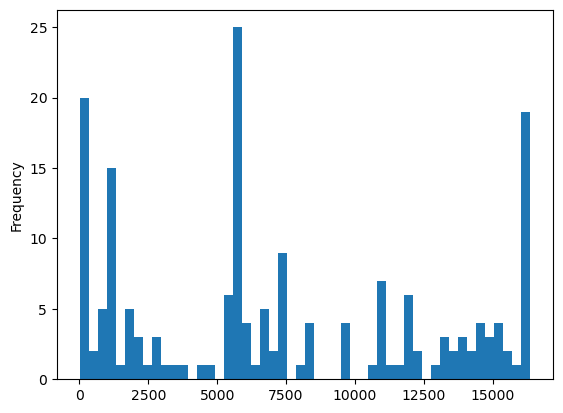

In [151]:
to_classify_denovo = denovo[['POS','REF','ALT','Tissue','Tissue_alt','Individual']]

# Group by POS, REF, and ALT, and count the number of unique individuals sharing the mutation
mutation_counts = to_classify_denovo.groupby(['POS', 'REF', 'ALT'])['Individual'].nunique().reset_index(name='Individuals_Share')

# Merge the count back into the original dataframe
to_classify_denovo = to_classify_denovo.merge(mutation_counts, on=['POS', 'REF', 'ALT'], how='left')

# Annotate indels with how many individuals share each mutation
classified_denovo = pd.merge( denovo, to_classify_denovo, how='left' )

# Plot histogram of positions.
classified_denovo['POS'].plot(kind='hist', bins=50)

classified_denovo

### Define cutoffs based on variant hotpot results

In [152]:
cutoff_hotspot = {
    'mouse': 1,
    'macaque': 2,
    'human': 1
}

### Exclude hotspots

In [153]:
# exclude_hotspots = classified_denovo[classified_denovo['Individuals_Share'] <= cutoff_hotspot ]

exclude_hotspots = classified_denovo[
    classified_denovo.apply(
        lambda row: row['Individuals_Share'] <= cutoff_hotspot.get(row['Species'], float('inf')), axis=1
    )
].drop_duplicates()

exclude_hotspots.to_csv( f"indels/indels.exclHotspots.denovo_{alignment}_{species}.tab", index=None, sep="\t" )

# Count mutations.
mutations = exclude_hotspots[['Species','Tissue', 'Age_group']].value_counts().reset_index(name='No_mutations')
mutations = pd.merge( mutations, sum_nucleotides, how='left' )
mutations['Frequency'] = mutations['No_mutations'] / mutations['Nucleotides']

# Convert the 'Age_group' and 'Tissue' columns to categorical types with specified order
mutations['Tissue'] = pd.Categorical(mutations['Tissue'], categories=tissue_order, ordered=True)
mutations['Age_group'] = pd.Categorical(mutations['Age_group'], categories=age_order, ordered=True)

# Sort by Age_group and Tissue explicitly to enforce the custom order
mutations = mutations.sort_values(by=['Tissue', 'Age_group']).reset_index(drop=True)

# if mutations.shape[0] > 1:
#     # Fisher's exact test between Younger and Older age groups.
#     mutations = perform_fishers_test(mutations)

# Export table.
mutations.to_csv( f"tables/freqs.exclHotspots.{alignment}_{species}.txt", index=None, sep="\t" )
mutations

,Species,Tissue,Age_group,No_mutations,Nucleotides,Frequency
0,human,Oo,Younger,29,451721281,6.419888e-08
1,human,Oo,Intermediate,24,556737175,4.310831e-08
2,human,Oo,Older,36,539602351,6.671580e-08
3,human,Sa,Younger,5,8775050,5.697973e-07
4,human,Sa,Intermediate,7,9702348,7.214748e-07
5,human,Sa,Older,3,7567919,3.964102e-07
6,human,Bl,Younger,4,7738150,5.169194e-07
7,human,Bl,Intermediate,3,5310791,5.648876e-07
8,human,Bl,Older,7,11250847,6.221754e-07


### Only Hotspots

In [154]:
# only_hotspots = classified_denovo[classified_denovo['Individuals_Share'] > cutoff_hotspot ]

only_hotspots = classified_denovo[
    classified_denovo.apply(
        lambda row: row['Individuals_Share'] > cutoff_hotspot.get(row['Species'], float('inf')), axis=1
    )
].drop_duplicates()

only_hotspots.to_csv( f"indels/indels.onlyHotspots.denovo_{alignment}_{species}.tab", index=None, sep="\t" )

# Count mutations.
mutations = only_hotspots[['Species','Tissue', 'Age_group']].value_counts().reset_index(name='No_mutations')
mutations = pd.merge( mutations, sum_nucleotides, how='left' )
mutations['Frequency'] = mutations['No_mutations'] / mutations['Nucleotides']

# Convert the 'Age_group' and 'Tissue' columns to categorical types with specified order
mutations['Tissue'] = pd.Categorical(mutations['Tissue'], categories=tissue_order, ordered=True)
mutations['Age_group'] = pd.Categorical(mutations['Age_group'], categories=age_order, ordered=True)

# Sort by Age_group and Tissue explicitly to enforce the custom order
mutations = mutations.sort_values(by=['Tissue', 'Age_group']).reset_index(drop=True)

# if mutations.shape[0] > 0:
#     # Fisher's exact test between Younger and Older age groups.
#     mutations = perform_fishers_test(mutations)

# Export table.
mutations.to_csv( f"tables/freqs.onlyHotspots.{alignment}_{species}.txt", index=None, sep="\t" )
mutations

,Species,Tissue,Age_group,No_mutations,Nucleotides,Frequency
0,human,Oo,Younger,16,451721281,3.542007e-08
1,human,Oo,Intermediate,11,556737175,1.975798e-08
2,human,Oo,Older,21,539602351,3.891755e-08
3,human,Sa,Younger,2,8775050,2.279189e-07
4,human,Sa,Intermediate,4,9702348,4.122713e-07
5,human,Sa,Older,3,7567919,3.964102e-07
6,human,Bl,Younger,2,7738150,2.584597e-07
7,human,Bl,Intermediate,3,5310791,5.648876e-07
8,human,Bl,Older,3,11250847,2.666466e-07
